# Matrix rank, low-rank approximation, SVD

## Matrix and linear spaces
- A matrix can be considered as a sequence of vectors that are columns of a matrix:

$$ A = [a_1, \ldots, a_m], $$

where $a_m \in \mathbb{C}^{n\times 1}$.  

- A matrix-by-vector product is equivalent to taking a linear combination of those columns 

$$ y =  Ax \quad \Longleftrightarrow \quad y = a_1 x_1 + a_2 x_2 + \ldots +a_m x_m. $$

- This is a special case of **block matrix notation** (columns are also blocks) that we have already seen (blocking to fit cache memory, Strassen algorithm).

## Matrix rank

- Rank of a matrix $A$ is a maximal number of linearly independent *columns* in a matrix $A$, or the **dimension of its column space** $= \text{dim} \, \text{im}(A)$.  

- You can also use linear combination of *rows* to define the rank, i.e. formally there are two ranks: column rank and row rank of a matrix.

## Full-rank matrix

- A matrix $A \in \mathbb{R}^{m \times n}$ is called of **full-rank**, if $\mathrm{rank}(A) = \min(m, n)$.

Suppose, we have a linear space, spanned by $n$ vectors. 
Let these vectors be random with elements from standard normal distribution $\mathcal{N}(0, 1)$.

**Q**: What is the probability of the fact that this subspace has dimension $m < n$?

**A**: Random matrix has full rank with probability 1.

## Dimensionality reduction

- A lot of data from real-world applications are high dimensional, for instance images (e.g. $512\times 512$ pixels), texts, graphs.
- However, working with high-dimensional data is not an easy task.
- Is it possible to reduce the dimensionality, preserving important relations between objects such as distance?

## Skeleton decomposition

A very useful representation for computation of the matrix rank is the **skeleton decomposition** and is closely related to the rank. 
This decompositions explains, why and how matrices of low rank can be compressed.

It can be graphically represented as follows:  
<img src="./skeleton.png" width='50%'>
or in the matrix form

$$ A = C \widehat{A}^{-1} R, $$

where $C$ are some $k=\mathrm{rank}(A)$ columns of $A$, $R$ are some $k$ rows of $A$ and  $\widehat{A}$ is the **nonsingular** submatrix on the intersection.

### Remark

We have not yet formally defined the inverse, so just a reminder:

- An inverse of the matrix $P$ is the matrix $Q = P^{-1}$ such that $ P Q = QP = I$.  
- If the matrix is square and has full rank then the inverse exists.

### A closer look on the skeleton decomposition

- Any rank-$r$ matrix can be written in the form

$$A = C \widehat{A}^{-1} R,$$

where $C$ is $n \times r$, $R$ is $r \times m$ and $\widehat{A}$ is $r \times r$, or 

$$ A = UV, $$

where $U$ and $V$ are not unique, e.g. $U = C \widehat{A}^{-1}$, $V=R$.

- The form $A = U V$ is standard for skeleton decomposition.

- Thus, every rank-$r$ matrix can be written as a product of a "skinny" ("tall") matrix $U$ by a "fat" ("short") matrix $V$.

In the index form, it is  

$$ a_{ij} = \sum_{\alpha=1}^r u_{i \alpha} v_{\alpha j}. $$

For rank 1, we have

$$ a_{ij} = u_i v_j, $$

i.e. it is a separation of indices and rank-$r$ is a sum of rank-$1$ matrices!

### Storage
It is interesting to note, that for the rank-$r$ matrix 

$$A = U V$$

only $U$ and $V$ can be stored, which gives us $(n+m) r$ parameters, so it can be used for compression. We can also compute matrix-by-vector $Ax$ product much faster:

* Multiplication $y = Vx$ costs $\mathcal{O}(mr)$ flops.
* Multiplication $z = Uy$ costs $\mathcal{O}(nr)$ flops.

The same works for addition, elementwise multiplication, etc.
For addition:

$$    A_1 + A_2 = U_1 V_1 + U_2 V_2 = [U_1|U_2] [V_1^\top|V_2^\top]^\top $$

In [3]:
#A fast matrix-by-vector product demo
import jax
import jax.numpy as jnp
n = 10000
r = 10
u = jax.random.normal(jax.random.PRNGKey(0), (n, r))
v = jax.random.normal(jax.random.PRNGKey(10), (n, r))
a = u @ v.T
x = jax.random.normal(jax.random.PRNGKey(1), (n,))
print(n*n/(2*n*r))
%timeit (a @ x).block_until_ready()
%timeit (u @ (v.T @ x)).block_until_ready()

500.0
8.64 ms ± 97.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
97.4 µs ± 1.16 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## Computing matrix rank
We can also try to compute the matrix rank using the built-in ```jnp.linalg.matrix_rank``` function

In [5]:
#Computing matrix rank
import jax.numpy as jnp
n = 50 
a = jnp.ones((n, n))
print('Rank of the matrix:', jnp.linalg.matrix_rank(a))
b = a + 1e-8 * jax.random.normal(jax.random.PRNGKey(10), (n, n))
print('Rank of the matrix:', jnp.linalg.matrix_rank(b, tol=1e-8))

Rank of the matrix: 1
Rank of the matrix: 6


<font color='red'> So, small perturbations might crucially affect the rank! </font>

### Instability of the matrix rank
For any rank-$r$ matrix $A$ with $r < \min(m, n)$ there is a matrix $B$ such that its rank is equal to $\min(m, n)$ and

$$ \Vert A - B \Vert = \epsilon. $$

**Q**: So, does this mean that numerically matrix rank has no meaning? (I.e., small perturbations lead to full rank!)

**A**: No. We should find a matrix $B$ such that $\|A-B\| = \epsilon$ and $B$ has minimal rank. So we can only compute rank with given accuracy $\epsilon$.
One of the approaches to compute matrix rank $r$ is SVD.

## Low rank approximation

The important problem in many applications is to find low-rank approximation of the given matrix with given accurcacy $\epsilon$ or rank $r$. <br>
Examples:
* principal component analysis
* recommender systems
* least squares
* neural network compression

These problems can be solved by SVD.

## Singular value decomposition
To compute low-rank approximation, we need to compute **singular value decomposition** (SVD).

**Theorem** Any matrix $A\in \mathbb{C}^{n\times m}$ can be written as a product of three matrices:  

$$ A = U \Sigma V^*, $$

where 
- $U$ is an $n \times K$ unitary matrix, 
- $V$ is an $m \times K$ unitary matrix, $K = \min(m, n)$,
- $\Sigma$ is a diagonal matrix with non-negative elements $\sigma_1 \geq  \ldots, \geq \sigma_K$ on the diagonal. 
- Moreover, if $\text{rank}(A) = r$, then $\sigma_{r+1} = \dots = \sigma_K = 0$.

# Eckart-Young theorem

The best low-rank approximation can be computed by SVD.

**Theorem:** Let $r < \text{rank}(A)$, $A_r = U_r \Sigma_r V_r^*$. Then

$$ \min_{\text{rank}(B)=r} \|A - B\|_2 = \|A - A_r\|_2 = \sigma_{r+1}. $$

The same holds for $\|\cdot\|_F$, but $\|A - A_r\|_F = \sqrt{\sigma_{r+1}^2 + \dots + \sigma_{\min (n,m)}^2}$.

## Main result on low-rank approximation

**Corollary:** computation of the best rank-$r$ approximation is equivalent to setting $\sigma_{r+1}= 0, \ldots, \sigma_K = 0$. The error 

$$ \min_{A_r} \Vert A - A_r \Vert_2 = \sigma_{r+1}, \quad \min_{A_r} \Vert A - A_r \Vert_F = \sqrt{\sigma_{r+1}^2 + \dots + \sigma_{K}^2} $$

that is why it is important to look at the decay of the singular values.

## Computing SVD

- Algorithms for the computation of the SVD are tricky and will be discussed later.

- But for numerics, we can use NumPy or JAX or PyTorch already!

Let us go back to the previous example

In [7]:
#Computing matrix rank
import jax.numpy as jnp
n = 50 
a = jnp.ones((n, n))
print('Rank of the matrix:', jnp.linalg.matrix_rank(a))
b = a + 1e-5 * jax.random.normal(jax.random.PRNGKey(-1), (n, n))
print('Rank of the matrix:', jnp.linalg.matrix_rank(b, tol=1e-3))

Rank of the matrix: 1
Rank of the matrix: 1


In [10]:
u, s, v = jnp.linalg.svd(b) #b = u@jnp.diag(s)@v 
print(s/s[0])
print(s[1]/s[0])
r = 1
u1 = u[:, :r]
s1 = s[:r]
v1 = v[:r, :]
a1 = u1.dot(jnp.diag(s1).dot(v1))
print(jnp.linalg.norm(b - a1, 2)/s[0])

[1.0000000e+00 2.6038917e-06 2.5778331e-06 2.4328988e-06 2.3946168e-06
 2.3161633e-06 2.1771170e-06 2.1350679e-06 2.0692341e-06 1.9072305e-06
 1.8897628e-06 1.7940382e-06 1.7782966e-06 1.7084487e-06 1.6727121e-06
 1.6017437e-06 1.5731581e-06 1.4549468e-06 1.4165987e-06 1.3679330e-06
 1.3424550e-06 1.2941907e-06 1.2687507e-06 1.2097146e-06 1.1957062e-06
 1.1181866e-06 1.1178938e-06 1.0891903e-06 1.0027645e-06 9.4870353e-07
 8.8112211e-07 8.7050188e-07 8.0722310e-07 7.6571308e-07 6.4515058e-07
 6.0674591e-07 5.7988444e-07 4.8432429e-07 4.7683716e-07 4.7153273e-07
 4.2522197e-07 3.7936982e-07 3.2457302e-07 2.7898491e-07 2.7062282e-07
 2.3026750e-07 1.8749994e-07 1.4638464e-07 1.2981367e-07 1.7708503e-08]
2.6038917e-06
2.6034543e-06


## Singular values of a random Gaussian matrix

What is the singular value decay of a random matrix?

(array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
        1.e+02]),
 [Text(0, 1e-06, '$\\mathdefault{10^{-6}}$'),
  Text(0, 1e-05, '$\\mathdefault{10^{-5}}$'),
  Text(0, 0.0001, '$\\mathdefault{10^{-4}}$'),
  Text(0, 0.001, '$\\mathdefault{10^{-3}}$'),
  Text(0, 0.01, '$\\mathdefault{10^{-2}}$'),
  Text(0, 0.1, '$\\mathdefault{10^{-1}}$'),
  Text(0, 1.0, '$\\mathdefault{10^{0}}$'),
  Text(0, 10.0, '$\\mathdefault{10^{1}}$'),
  Text(0, 100.0, '$\\mathdefault{10^{2}}$')])

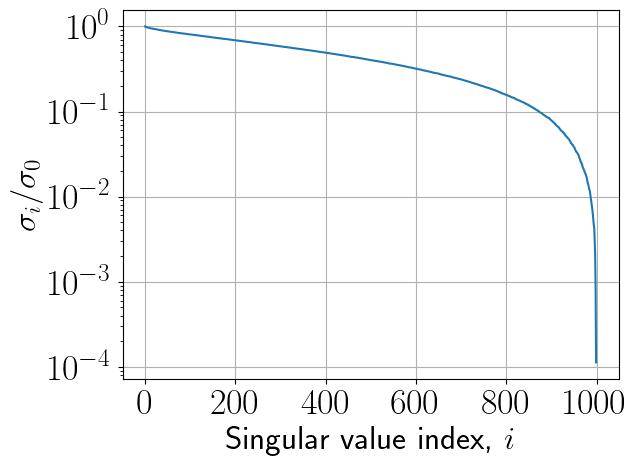

In [14]:
import numpy as np
import matplotlib.pyplot as plt
n = 1000
a = jax.random.normal(jax.random.PRNGKey(244747), (n, n))
u, s, v = jnp.linalg.svd(a)
plt.semilogy(s/s[0])
plt.ylabel(r"$\sigma_i / \sigma_0$", fontsize=24)
plt.xlabel(r"Singular value index, $i$", fontsize=24)
plt.grid(True)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)

## Applications of SVD

- SVD is extremely important in computational science and engineering.

- It has many names: Principal component analysis, Proper Orthogonal Decomposition, Empirical Orthogonal Functions

- Now we will consider compression of **dense** matrix and active subspaces method 

## Dense matrix compression

Dense matrices typically require $N^2$ elements to be stored. A rank-$r$ approximation can reduces this number to $\mathcal{O}(Nr)$

DeviceArray(-0.3372376, dtype=float32)

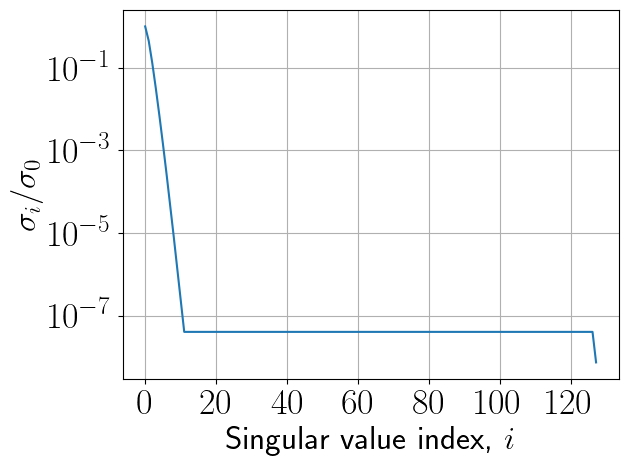

In [26]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

n = 256
a = [[1.0/(i - j + 0.5) for i in range(n)] for j in range(n)]
a = np.array(a)
#u, s, v = np.linalg.svd(a)
u, s, v = jnp.linalg.svd(a[n//2:, :n//2])
plt.semilogy(s/s[0])
plt.ylabel(r"$\sigma_i / \sigma_0$", fontsize=24)
plt.xlabel(r"Singular value index, $i$", fontsize=24)
plt.grid(True)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
#s[0] - jnp.pi
#u, s, v = jnp.linalg.svd(a[:128:, :128])
#print(s[0]-jnp.pi)

## Compression of parameters in fully-connected neural networs

- One of the main building blocks of the modern deep neural networks is **fully-connected layer** a.k.a. **linear layer**
- This layer implements the action of a linear function to an input vector: $f(x) = Wx + b$, where $W$ is a trainable matrix and $b$ is a trainable bias vector
- Both $W$ and $b$ are updated during training of the network according to some optimization method, i.e. SGD, Adam, etc...
- However, the storing of the trained optimal parameters ($W$ and $b$) can be **prohibitive** if you want to port your trained network to the device, where memory is limited
- As a possible recipe, you can **compress** matrices $W_i$ from the $i$-th linear layer with the truncated SVD based on the singular values!
- What do you get after such apprioximation of $W$?
    - memory efficient storage
    - faster inference
    - moderate degradation of the accuracy in solving the target task, i.e. image classification
    